# 6.8610  PROJECT

## Install and import libraries

In [ ]:
!pip install datasets
!pip install transformers[torch]
!pip install tokenizers
!pip install huggingface_hub
!pip install tqdm
!pip install matplotlib

In [8]:
import numpy as np
from datasets import Dataset, load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
import os
import json
import torch
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt

c:\Users\yezix\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Helpers

### Prepare Dataset
Helper functions for loading models, tokenizers, and datasets, and preprocessing data.

In [4]:
def get_latest_checkpoint(checkpoint_dir):
    """
    Get the directory containing the latest checkpoint of a pre-trainied model.
    
    Parameters:
    - checkpoint_dir (str): Directory containing all checkpoints for the model.

    Returns:
    str: Directory containing the latest checkpoint.
    """
    # List all directories in the results folder
    all_checkpoints = [d for d in os.listdir(checkpoint_dir) if os.path.isdir(os.path.join(checkpoint_dir, d))]
    # Extract the checkpoint numbers
    checkpoint_numbers = [int(d.split("-")[1]) for d in all_checkpoints if d.startswith("checkpoint-")]
    # Find the folder name of the latest checkpoint
    latest_checkpoint_folder = f"{checkpoint_dir}/checkpoint-{max(checkpoint_numbers)}"
    
    return latest_checkpoint_folder

In [5]:
def load_tokenizer(checkpoint_dir):
    """
    Load the tokenizer of a checkpoint.
    
    Parameters:
    - checkpoint_dir (str): Directory containing the checkpoint to be loaded.

    Returns:
    transformers.AutoTokenizer: Tokenizer of the specified checkpoint.
    """
    checkpoint = get_latest_checkpoint(checkpoint_dir)
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    return tokenizer

In [6]:
def load_datasets(dataset_dir):
    """
    Load entity tracking evaluation datasets.
    
    Parameters:
    - dataset_dir (str): Directory containing the entity tracking datasets.

    Returns:
    - tuple (datasets.Dataset, datasets.Dataset):
        - dataset_train: Training dataset containing two-shot prompting examples.
        - dataset_test: Testing dataset.
    """
    dataset_train_path = f"{dataset_dir}/train.jsonl"
    #dataset_test_path = f"{dataset_dir}/test.jsonl"
    dataset_test_path = f"{dataset_dir}/test_small.jsonl"
    dataset_train = load_dataset('json', data_files=dataset_train_path)['train']
    dataset_test = load_dataset('json', data_files=dataset_test_path)['train']
    return dataset_train, dataset_test

In [7]:
PROMPT = """
Given the description after "Description:", complete the last sentence with a true statement about the contents
of the specified box according to the description.
Description: 
"""

def tokenize_dataset(dataset, tokenizer):
    """
    Prepend the specified prompt to questions and tokenize the input dataset.

    Parameters:
    - dataset (datasets.Dataset): Dataset to be tokenized.
    - tokenizer (transformers.AutoTokenizer): Tokenizer to be used.

    Returns:
    torch.utils.data.TensorDataset: Tokenized dataset containing input_ids, attention_masks, and labels.
    """
    input_ids = []
    attention_masks = []
    labels = []

    for entry in tqdm(dataset):
        # tokenize problem
        input_data = PROMPT + entry['sentence_masked'][:-15] + ":"
        input_encoding = tokenizer(input_data, truncation=True, padding='max_length', max_length=512, return_attention_mask = True, return_tensors = 'pt')
        input_ids.append(input_encoding['input_ids'])
        attention_masks.append(input_encoding['attention_mask'])
         # tokenize answer
        target = entry['masked_content'][13:]
        target_encoding = tokenizer(target, truncation=True, padding='max_length', max_length=512, return_attention_mask = True, return_tensors = 'pt')
        target_input_ids = target_encoding['input_ids']
        target_input_ids[target_input_ids == tokenizer.pad_token_id] = -100
        labels.append(target_input_ids)

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.cat(labels, dim=0)
    tokenized_data = TensorDataset(input_ids, attention_masks, labels)
    return tokenized_data

In [8]:
BATCH_SIZE = 4

def make_dataloader(tokenized_dataset):
    """
    Create a dataloader for the given dataset.

    Parameters:
    - tokenized_dataset (torch.utils.data.TensorDataset): Tokenized dataset containing input_ids, attention_masks, and labels.

    Returns:
    torch.utils.data.DataLoader: DataLoader configured with the provided tokenized dataset.
    """
    dataloader = DataLoader(tokenized_dataset, batch_size=BATCH_SIZE, shuffle=False)
    return dataloader

### Two-Shot Training
Helper functions for training a model with two examples.

In [9]:
def load_model(checkpoint_dir):
    """
    Load a pre-trained language model from the latest checkpoint in the specified directory.

    Parameters:
    - checkpoint_dir (str): Directory containing checkpoints of the model.

    Returns:
    transformers.AutoModelForSeq2SeqLM: Loaded sequence-to-sequence language model.
    """
    checkpoint = get_latest_checkpoint(checkpoint_dir)
    model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint).to(device)
    return model

In [10]:
def train_model(model, train_loader):
    """
    Train the provided model using the specified DataLoader.
    The function uses the AdamW optimizer with a learning rate of 1e-4 and epsilon of 1e-8. Training is performed for 5 epochs.

    Parameters:
    - model (transformers.AutoModelForSeq2SeqLM): The sequence-to-sequence language model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader providing batches of tokenized training data.

    Returns:
    None
    """
    optimizer = AdamW(model.parameters(), lr = 1e-4, eps = 1e-8)

    for _ in tqdm(range(5)):

        total_train_loss = 0
        model.train()

        for batch in tqdm(train_loader):

          input_ids = batch[0].to(device)
          input_mask = batch[1].to(device)
          labels = batch[2].to(device)
          
          model.zero_grad()
          outputs = model(input_ids, attention_mask=input_mask, labels=labels)
          loss = outputs.loss
          total_train_loss += loss
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()
    
    print(f"Total train loss: {total_train_loss}.")

### Generate Predictions
Helper functions for generating predictions using a model.

In [11]:
def make_prediction_all(model, tokenizer, dataloader):
    """
    Generate predictions for data in the provided DataLoader using the provided model.

    Parameters:
    - model (transformers.AutoModelForSeq2SeqLM): The sequence-to-sequence language model used for generating predictions.
    - tokenizer (transformers.AutoTokenizer): The tokenizer used for decoding generated sequences.
    - dataloader (torch.utils.data.DataLoader): DataLoader providing batches of tokenized input data for prediction.

    Returns:
    list: A list containing the generated prediction sequences.
    """
    model_predictions = []

    for batch in tqdm(dataloader):

        # Generate sequences for the batch
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        sequence_ids = model.generate(input_ids, attention_mask=input_mask)
        sequences = tokenizer.batch_decode(sequence_ids, skip_special_tokens=True)

        # Accumulate generated sequences
        model_predictions.extend(sequences)

    return model_predictions

In [12]:
def add_prediction_to_data(model_preds, model_name, lr, dataset):
    """
    Add provided model predictions to the provided dataset as a new prediction column .

    Parameters:
    - model_preds (list): List of model predictions to be added.
    - model_name (str): Name of the model used for predictions.
    - lr (str or float): Learning rate associated with the provided model.
    - dataset (datasets.Dataset): The dataset to which the predictions will be added.

    Returns:
    datasets.Dataset: The input dataset with an additional column containing the model predictions.
    """
    dataset = dataset.add_column(f"model_{model_name}_{lr}_pred", model_preds)
    return dataset

## Evaluation Loop
Load models and data, process data, and generate and save predictions.

In [13]:
dataset_train, dataset_test = load_datasets("./eval/current_use")

In [14]:
# from scratch
dataset_test_all = Dataset.from_dict({
    # problem and solution
    'sentence_masked': dataset_test['sentence_masked'],
    'masked_content': dataset_test['masked_content'],
    # metadata
    'sample_id': dataset_test['sample_id'],
    'numops': dataset_test['numops'],
    })

In [35]:
# add to existing
# dataset_test_all = load_dataset('json', data_files="./results/eval/preds/preds_twoshot_small.jsonl")['train']

In [36]:
def evaluate_model(model_name="base", lr="3e-4", zeroshot=True):
    """
    Evaluate a sequence-to-sequence language model's performance.

    Parameters:
    - model_name (str): Name of the pre-trained model to evaluate (default is "base").
    - lr (str or float): Learning rate associated with the model (default is "3e-4").
    - zeroshot (bool): Flag indicating whether to perform zero-shot evaluation (default is True).

    Returns:
    list: A list containing the generated predictions based on the specified model and evaluation settings.
    """
    # prepare datasets
    tokenizer = load_tokenizer(f"./results/{model_name}/{lr}/")
    tokenized_dataset_train = tokenize_dataset(dataset_train, tokenizer)
    tokenized_dataset_test = tokenize_dataset(dataset_test, tokenizer)
    train_loader = make_dataloader(tokenized_dataset_train)
    test_loader = make_dataloader(tokenized_dataset_test)

    # load and potentially train model
    model = load_model(f"./results/{model_name}/{lr}/")
    if not zeroshot:
        train_model(model, train_loader)

    # make predictions
    model_preds = make_prediction_all(model, tokenizer, test_loader)
    if zeroshot:
        dataset_test.to_json(f"./results/eval/preds/preds_{model_name}_{lr}_zeroshot.jsonl", orient="records")
    else:
        dataset_test.to_json(f"./results/eval/preds/preds_{model_name}_{lr}_twoshot.jsonl", orient="records")
    
    # garbage collection
    del model, tokenizer, tokenized_dataset_train, tokenized_dataset_test, train_loader, test_loader
    gc.collect()
    torch.cuda.empty_cache()

    return model_preds

In [17]:
# main
model_names = ["general", "code", "math", "general_code", "general_math"]
lrs = ["3e-3", "3e-4", "3e-5"]

In [ ]:
for model_name in model_names:
    for lr in lrs:
        preds = evaluate_model(model_name=model_name, lr=lr, zeroshot=False)
        dataset_test_all = add_prediction_to_data(preds, model_name, lr, dataset_test_all)

In [39]:
# extension
model_names_extension = ["small_general", "small_code", "small_math", "prompt_code", "prompt_math"]
lrs_extension = ["3e-4", "3e-5"]

In [ ]:
for model_name in model_names_extension:
    for lr in lrs_extension:
        preds = evaluate_model(model_name=model_name, lr=lr, zeroshot=False)
        dataset_test_all = add_prediction_to_data(preds, model_name, lr, dataset_test_all)

In [41]:
dataset_test_all[:7]

{'sentence_masked': ['Box 0 contains the boat and the shoe and the television, Box 1 contains the camera and the car and the plane, Box 2 contains the cake, Box 3 contains the fan, Box 4 contains the cross and the file and the note, Box 5 contains the chemical, Box 6 contains nothing. Move the cake from Box 2 to Box 6. Put the dish and the stone into Box 5. Move the television from Box 0 to Box 6. Put the drink into Box 2. Move the chemical and the stone from Box 5 to Box 2. Box 0 contains <extra_id_0> .',
  'Box 0 contains the boat and the shoe and the television, Box 1 contains the camera and the car and the plane, Box 2 contains the cake, Box 3 contains the fan, Box 4 contains the cross and the file and the note, Box 5 contains the chemical, Box 6 contains nothing. Move the cake from Box 2 to Box 6. Put the dish and the stone into Box 5. Move the television from Box 0 to Box 6. Put the drink into Box 2. Move the chemical and the stone from Box 5 to Box 2. Box 1 contains <extra_id_0>

In [45]:
dataset_test_all.to_json(f"./results/eval/preds/preds_twoshot_small.jsonl", orient="records")

Creating json from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 86.91ba/s]


199376

## Metrics
Compute and plot evaluation metrics (accuracy, precision, recall, f1 score).

### Helpers
Helper functions for loading and cleaning predictions, and compute metrics.

In [1]:
def load_dataset_if_not_already(dataset_path="./results/eval/preds/preds_twoshot.jsonl"):
    """
    Load a dataset from the specified JSON file path if it does not exist in the current name space already.

    Parameters:
    - dataset_path (str): The path to the JSON file containing the dataset (default is "./results/eval/preds/preds_twoshot.jsonl").

    Returns:
    datasets.Dataset: The loaded dataset.
    """
    if "dataset_test_all" not in locals():
        dataset_test_all = load_dataset('json', data_files=dataset_path)['train']
    return dataset_test_all

In [2]:
def clean_labels(labels):
    """
    Clean labels by removing the leading masked token.

    Parameters:
    - labels (list): List of labels containing masked tokens.

    Returns:
    list: A list of cleaned labels without the leading masked token.
    """
    # removes leading masked token
    cln_labels = list(map(lambda label: label[13:], labels))
    return cln_labels

In [3]:
def compute_metrics_for_model(labels_combined, preds_combined):
    """
    Compute evaluation metrics for a model's predictions.

    Parameters:
    - labels_combined (list): List of strings containing ground truth labels.
    - preds_combined (list): List of strings containing model predictions.

    Returns:
    Tuple (float, float, float, float): A tuple containing the computed evaluation metrics in the order:
    - Accuracy
    - Precision
    - Recall
    - F1 Score
    """
    # split labels and preds into list of items
    label_items = list(map(lambda label: label.split(" and "), labels_combined))
    preds_items = list(map(lambda pred: pred.split(" and "), preds_combined))

    # count predictions
    total_preds, total_correct, true_pos, false_pos, false_neg = 0, 0, 0, 0, 0
    for i in range(len(label_items)):
        labels, preds = label_items[i], preds_items[i]
        for label in labels:
            if (label in preds):     # correct answer that pred also has
                total_correct += 1
                true_pos += 1
            else:                    # correct answer that pred does not have
                false_neg += 1
            total_preds += 1         # count the item into total regardless
        for pred in preds:
            if (pred not in labels): # item that pred has but is not in answer
                false_pos += 1

    # compute metrics
    accuracy = total_correct / total_preds
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    f1 = (precision * recall) / (precision + recall) if (precision + recall > 0) else 0

    print(f"accuracy: {accuracy}")
    print(f"precision: {precision}")
    print(f"recall: {recall}")
    print(f"f1 score: {f1}")

    return accuracy, precision, recall, f1

### Actual Computation
Compute metrics for a given model.

In [10]:
def compute_metrics(model_name="base", lr="3e-4", dataset_path="./results/eval/preds/preds_twoshot.jsonl"):
    """
    Compute evaluation metrics for a model on a given dataset.

    Parameters:
    - model_name (str): Name of the pre-trained model used for predictions (default is "base").
    - lr (str or float): Learning rate associated with the model (default is "3e-4").
    - dataset_path (str): Path to the JSON file containing the dataset (default is "./results/eval/preds/preds_twoshot.jsonl").

    Returns:
    Tuple (float, float, float, float): A tuple containing the computed evaluation metrics in the order:
    - Accuracy
    - Precision
    - Recall
    - F1 Score
    """
    dataset_test_all = load_dataset_if_not_already(dataset_path=dataset_path)
    cln_labels = clean_labels(dataset_test_all['masked_content'])
    metrics = compute_metrics_for_model(cln_labels, dataset_test_all[f"model_{model_name}_{lr}_pred"])
    return metrics

##### Main

In [5]:
model_names = ["general", "code", "math", "general_code", "general_math"]
lrs = ["3e-3", "3e-4", "3e-5"]

In [6]:
acc_by_model_and_lr, pre_by_model_and_lr, rec_by_model_and_lr, f1_by_model_and_lr = dict(), dict(), dict(), dict()

In [11]:
for model_name in model_names:
    for lr in lrs:
        print(f"{model_name}, lr={lr}:")
        accuracy, precision, recall, f1 = compute_metrics(
            model_name=model_name, lr=lr,
            dataset_path="./results/eval/preds/preds_twoshot_small.jsonl"
            )
        print()
        if (lr in acc_by_model_and_lr):
            acc_by_model_and_lr[lr].append(accuracy)
            pre_by_model_and_lr[lr].append(precision)
            rec_by_model_and_lr[lr].append(recall)
            f1_by_model_and_lr[lr].append(f1)
        else:
            acc_by_model_and_lr[lr] = [accuracy]
            pre_by_model_and_lr[lr] = [precision]
            rec_by_model_and_lr[lr] = [recall]
            f1_by_model_and_lr[lr] = [f1]

general, lr=3e-3:
accuracy: 0.005714285714285714
precision: 0.01
recall: 0.005714285714285714
f1 score: 0.003636363636363636

general, lr=3e-4:
accuracy: 0.4
precision: 0.4166666666666667
recall: 0.4
f1 score: 0.20408163265306126

general, lr=3e-5:
accuracy: 0.38857142857142857
precision: 0.43312101910828027
recall: 0.38857142857142857
f1 score: 0.20481927710843376

code, lr=3e-3:
accuracy: 0.0
precision: 0.0
recall: 0.0
f1 score: 0

code, lr=3e-4:
accuracy: 0.10857142857142857
precision: 0.10674157303370786
recall: 0.10857142857142857
f1 score: 0.05382436260623229

code, lr=3e-5:
accuracy: 0.44
precision: 0.4117647058823529
recall: 0.44
f1 score: 0.21270718232044197

math, lr=3e-3:
accuracy: 0.011428571428571429
precision: 0.007874015748031496
recall: 0.011428571428571429
f1 score: 0.004662004662004662

math, lr=3e-4:
accuracy: 0.09142857142857143
precision: 0.08290155440414508
recall: 0.09142857142857143
f1 score: 0.043478260869565216

math, lr=3e-5:
accuracy: 0.3314285714285714
prec

#### Extension - Dataset Size

In [12]:
model_names_extension = ["general", "code", "math"]
sizes = ["1887", "500"]

In [13]:
acc_by_model_and_size, pre_by_model_and_size, rec_by_model_and_size, f1_by_model_and_size = dict(), dict(), dict(), dict()

In [14]:
for model_name in model_names_extension:
    for size in sizes:
        model_name = model_name if size == "1887" else f"small_{model_name}"
        print(f"{model_name}, size={size}:")
        accuracy, precision, recall, f1 = compute_metrics(
            model_name=model_name, lr="3e-5",
            dataset_path="./results/eval/preds/preds_twoshot_small.jsonl"
            )
        print()
        if (size in acc_by_model_and_size):
            acc_by_model_and_size[size].append(accuracy)
            pre_by_model_and_size[size].append(precision)
            rec_by_model_and_size[size].append(recall)
            f1_by_model_and_size[size].append(f1)
        else:
            acc_by_model_and_size[size] = [accuracy]
            pre_by_model_and_size[size] = [precision]
            rec_by_model_and_size[size] = [recall]
            f1_by_model_and_size[size] = [f1]

general, size=1887:
accuracy: 0.38857142857142857
precision: 0.43312101910828027
recall: 0.38857142857142857
f1 score: 0.20481927710843376

small_general, size=500:
accuracy: 0.3657142857142857
precision: 0.3855421686746988
recall: 0.3657142857142857
f1 score: 0.187683284457478

code, size=1887:
accuracy: 0.44
precision: 0.4117647058823529
recall: 0.44
f1 score: 0.21270718232044197

small_code, size=500:
accuracy: 0.3485714285714286
precision: 0.3961038961038961
recall: 0.3485714285714286
f1 score: 0.18541033434650459

math, size=1887:
accuracy: 0.3314285714285714
precision: 0.3717948717948718
recall: 0.3314285714285714
f1 score: 0.17522658610271905

small_math, size=500:
accuracy: 0.4228571428571429
precision: 0.42045454545454547
recall: 0.4228571428571429
f1 score: 0.21082621082621084



#### Extension - Prompt

In [15]:
model_names_extension = ["general", "code", "math"]
prompts = ["simple", "tracking"]

In [16]:
acc_by_model_and_prompt, pre_by_model_and_prompt, rec_by_model_and_prompt, f1_by_model_and_prompt = dict(), dict(), dict(), dict()

In [17]:
for model_name in model_names_extension:
    for prompt in prompts:
        model_name = model_name if prompt == "simple" else f"prompt_{model_name}"
        print(f"{model_name}, size={size}:")
        if (model_name == "prompt_general"):
            accuracy, precision, recall, f1 = 0, 0, 0, 0
        else:
            accuracy, precision, recall, f1 = compute_metrics(
                model_name=model_name, lr="3e-5",
                dataset_path="./results/eval/preds/preds_twoshot_small.jsonl"
                )
        print()
        if (prompt in acc_by_model_and_prompt):
            acc_by_model_and_prompt[prompt].append(accuracy)
            pre_by_model_and_prompt[prompt].append(precision)
            rec_by_model_and_prompt[prompt].append(recall)
            f1_by_model_and_prompt[prompt].append(f1)
        else:
            acc_by_model_and_prompt[prompt] = [accuracy]
            pre_by_model_and_prompt[prompt] = [precision]
            rec_by_model_and_prompt[prompt] = [recall]
            f1_by_model_and_prompt[prompt] = [f1]

general, size=500:
accuracy: 0.38857142857142857
precision: 0.43312101910828027
recall: 0.38857142857142857
f1 score: 0.20481927710843376

prompt_general, size=500:

code, size=500:
accuracy: 0.44
precision: 0.4117647058823529
recall: 0.44
f1 score: 0.21270718232044197

prompt_code, size=500:
accuracy: 0.3942857142857143
precision: 0.3689839572192513
recall: 0.3942857142857143
f1 score: 0.19060773480662985

math, size=500:
accuracy: 0.3314285714285714
precision: 0.3717948717948718
recall: 0.3314285714285714
f1 score: 0.17522658610271905

prompt_math, size=500:
accuracy: 0.4514285714285714
precision: 0.40512820512820513
recall: 0.4514285714285714
f1 score: 0.2135135135135135



### Plotting
Plot side-by-side bar charts for evaluation metrics.

#### Main

In [18]:
# set width of bars
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(model_names))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

model_names_on_plot = ["General", "Code", "Math", "General+Code", "General+Math"]

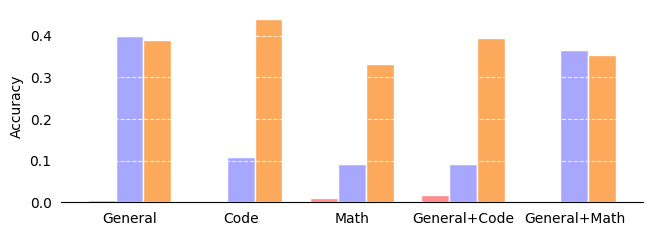

In [19]:
fig = plt.figure(figsize=(7.5, 2.5))

plt.bar(r1, acc_by_model_and_lr["3e-3"], width=barWidth, edgecolor='white', color="#fe8c8c", label='3e-3')
plt.bar(r2, acc_by_model_and_lr["3e-4"], width=barWidth, edgecolor='white', color="#a8a7ff", label='3e-4')
plt.bar(r3, acc_by_model_and_lr["3e-5"], width=barWidth, edgecolor='white', color="#fca95b", label='3e-5')
plt.grid(axis='y', linestyle='--', color="white", alpha=0.8)
#plt.ylim(0, 0.45)

plt.ylabel('Accuracy')
plt.xlabel('')
plt.xticks([r + barWidth for r in range(len(model_names))], model_names_on_plot)
plt.tick_params(axis='both', which='both', left=False, right=False, bottom=False, top=False)

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.legend(loc='upper center', ncol=3)

plt.savefig(f"./results/eval/plots/accuracy.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

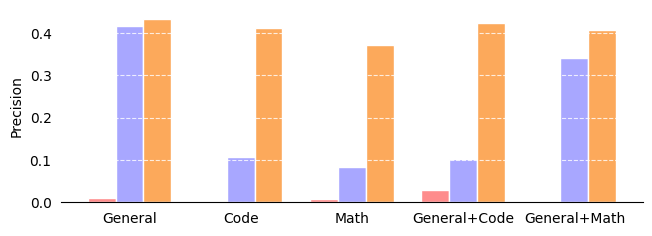

In [144]:
fig = plt.figure(figsize=(7.5, 2.5))

plt.bar(r1, pre_by_model_and_lr["3e-3"], width=barWidth, edgecolor='white', color="#fe8c8c", label='3e-3')
plt.bar(r2, pre_by_model_and_lr["3e-4"], width=barWidth, edgecolor='white', color="#a8a7ff", label='3e-4')
plt.bar(r3, pre_by_model_and_lr["3e-5"], width=barWidth, edgecolor='white', color="#fca95b", label='3e-5')
plt.grid(axis='y', linestyle='--', color="white", alpha=0.8)
#plt.ylim(0, 0.45)

plt.ylabel('Precision')
plt.xlabel('')
plt.xticks([r + barWidth for r in range(len(model_names))], model_names_on_plot)
plt.tick_params(axis='both', which='both', left=False, right=False, bottom=False, top=False)

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.legend(loc='upper center', ncol=3)

plt.savefig(f"./results/eval/plots/precision.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

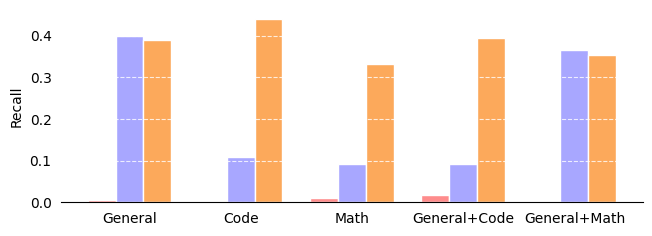

In [145]:
fig = plt.figure(figsize=(7.5, 2.5))

plt.bar(r1, rec_by_model_and_lr["3e-3"], width=barWidth, edgecolor='white', color="#fe8c8c", label='3e-3')
plt.bar(r2, rec_by_model_and_lr["3e-4"], width=barWidth, edgecolor='white', color="#a8a7ff", label='3e-4')
plt.bar(r3, rec_by_model_and_lr["3e-5"], width=barWidth, edgecolor='white', color="#fca95b", label='3e-5')
plt.grid(axis='y', linestyle='--', color="white", alpha=0.8)
#plt.ylim(0, 0.45)

plt.ylabel('Recall')
plt.xlabel('')
plt.xticks([r + barWidth for r in range(len(model_names))], model_names_on_plot)
plt.tick_params(axis='both', which='both', left=False, right=False, bottom=False, top=False)

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.legend(loc='upper center', ncol=3)

plt.savefig(f"./results/eval/plots/recall.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

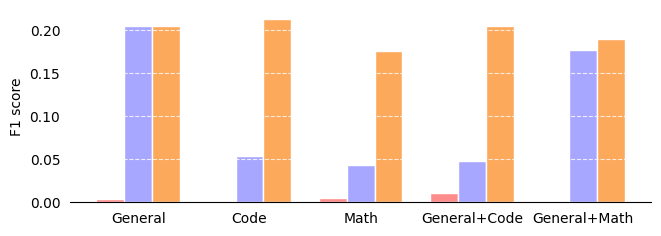

In [146]:
fig = plt.figure(figsize=(7.5, 2.5))

plt.bar(r1, f1_by_model_and_lr["3e-3"], width=barWidth, edgecolor='white', color="#fe8c8c", label='3e-3')
plt.bar(r2, f1_by_model_and_lr["3e-4"], width=barWidth, edgecolor='white', color="#a8a7ff", label='3e-4')
plt.bar(r3, f1_by_model_and_lr["3e-5"], width=barWidth, edgecolor='white', color="#fca95b", label='3e-5')
plt.grid(axis='y', linestyle='--', color="white", alpha=0.8)
#plt.ylim(0, 0.45)

plt.ylabel('F1 score')
plt.xlabel('')
plt.xticks([r + barWidth for r in range(len(model_names))], model_names_on_plot)
plt.tick_params(axis='both', which='both', left=False, right=False, bottom=False, top=False)

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.legend(loc='upper center', ncol=3)

plt.savefig(f"./results/eval/plots/f1.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

#### Extension - Sizes

In [20]:
# set width of bars
barWidth = 0.3

# Set position of bar on X axis
r1 = np.arange(len(model_names_extension)) + 0.15
r2 = [x + barWidth for x in r1]

model_names_on_plot = ["General", "Code", "Math"]

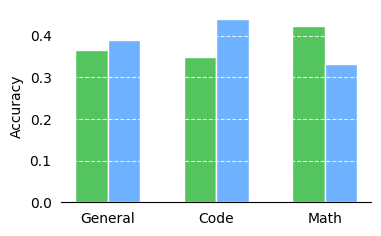

In [29]:
fig = plt.figure(figsize=(4, 2.5))

plt.bar(r1, acc_by_model_and_size["500"], width=barWidth, edgecolor='white', color="#54c45e", label='500')
plt.bar(r2, acc_by_model_and_size["1887"], width=barWidth, edgecolor='white', color="#6db1ff", label='1887')
plt.grid(axis='y', linestyle='--', color="white", alpha=0.8)
#plt.ylim(0, 0.53)

plt.ylabel('Accuracy')
plt.xlabel('')
plt.xticks([r + barWidth for r in range(len(model_names_extension))], model_names_on_plot)
plt.tick_params(axis='both', which='both', left=False, right=False, bottom=False, top=False)

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.legend(loc='upper center', ncol=3)

plt.savefig(f"./results/eval/plots/accuracy_size.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

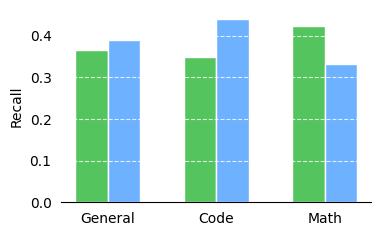

In [27]:
fig = plt.figure(figsize=(4, 2.5))

plt.bar(r1, rec_by_model_and_size["500"], width=barWidth, edgecolor='white', color="#54c45e", label='500')
plt.bar(r2, rec_by_model_and_size["1887"], width=barWidth, edgecolor='white', color="#6db1ff", label='1887')
plt.grid(axis='y', linestyle='--', color="white", alpha=0.8)
#plt.ylim(0, 0.53)

plt.ylabel('Recall')
plt.xlabel('')
plt.xticks([r + barWidth for r in range(len(model_names_extension))], model_names_on_plot)
plt.tick_params(axis='both', which='both', left=False, right=False, bottom=False, top=False)

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.legend(loc='upper center', ncol=3)

plt.savefig(f"./results/eval/plots/recall_size.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

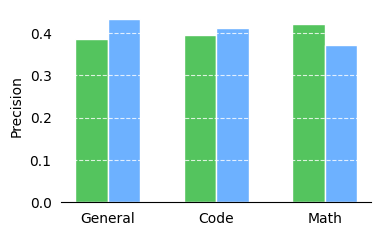

In [30]:
fig = plt.figure(figsize=(4, 2.5))

plt.bar(r1, pre_by_model_and_size["500"], width=barWidth, edgecolor='white', color="#54c45e", label='500')
plt.bar(r2, pre_by_model_and_size["1887"], width=barWidth, edgecolor='white', color="#6db1ff", label='1887')
plt.grid(axis='y', linestyle='--', color="white", alpha=0.8)
#plt.ylim(0, 0.53)

plt.ylabel('Precision')
plt.xlabel('')
plt.xticks([r + barWidth for r in range(len(model_names_extension))], model_names_on_plot)
plt.tick_params(axis='both', which='both', left=False, right=False, bottom=False, top=False)

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.legend(loc='upper center', ncol=3)

plt.savefig(f"./results/eval/plots/precision_size.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

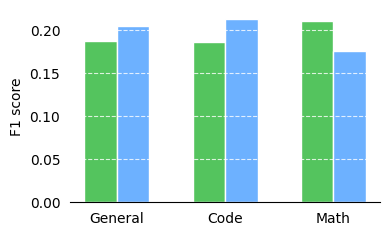

In [35]:
fig = plt.figure(figsize=(4, 2.5))

plt.bar(r1, f1_by_model_and_size["500"], width=barWidth, edgecolor='white', color="#54c45e", label='500')
plt.bar(r2, f1_by_model_and_size["1887"], width=barWidth, edgecolor='white', color="#6db1ff", label='1887')
plt.grid(axis='y', linestyle='--', color="white", alpha=0.8)
#plt.ylim(0, 0.53)

plt.ylabel('F1 score')
plt.xlabel('')
plt.xticks([r + barWidth for r in range(len(model_names_extension))], model_names_on_plot)
plt.tick_params(axis='both', which='both', left=False, right=False, bottom=False, top=False)

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.legend(loc='upper center', ncol=3)

plt.savefig(f"./results/eval/plots/f1_size.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

#### Extension - Prompts

In [181]:
# set width of bars
barWidth = 0.3

# Set position of bar on X axis
r1 = np.arange(len(model_names_extension)) + 0.15
r2 = [x + barWidth for x in r1]

model_names_on_plot = ["General", "Code", "Math"]

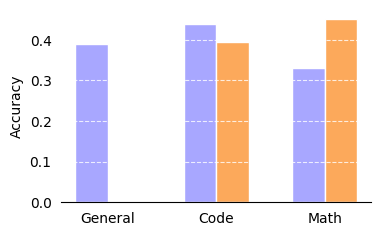

In [200]:
fig = plt.figure(figsize=(4, 2.5))

plt.bar(r1, acc_by_model_and_prompt["simple"], width=barWidth, edgecolor='white', color="#a8a7ff", label='simple')
plt.bar(r2, acc_by_model_and_prompt["tracking"], width=barWidth, edgecolor='white', color="#fca95b", label='tracking')
plt.grid(axis='y', linestyle='--', color="white", alpha=0.8)
#plt.ylim(0, 0.53)

plt.ylabel('Accuracy')
plt.xlabel('')
plt.xticks([r + barWidth for r in range(len(model_names_extension))], model_names_on_plot)
plt.tick_params(axis='both', which='both', left=False, right=False, bottom=False, top=False)

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.legend(loc='upper center', ncol=3)

plt.savefig(f"./results/eval/plots/accuracy_prompt.png")
plt.show()

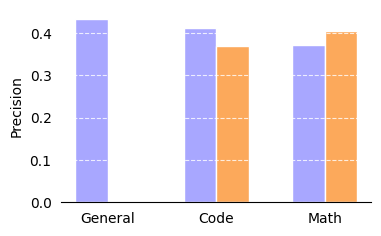

In [184]:
fig = plt.figure(figsize=(4, 2.5))

plt.bar(r1, pre_by_model_and_prompt["simple"], width=barWidth, edgecolor='white', color="#a8a7ff", label='simple')
plt.bar(r2, pre_by_model_and_prompt["tracking"], width=barWidth, edgecolor='white', color="#fca95b", label='tracking')
plt.grid(axis='y', linestyle='--', color="white", alpha=0.8)
#plt.ylim(0, 0.53)

plt.ylabel('Precision')
plt.xlabel('')
plt.xticks([r + barWidth for r in range(len(model_names_extension))], model_names_on_plot)
plt.tick_params(axis='both', which='both', left=False, right=False, bottom=False, top=False)

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.legend(loc='upper center', ncol=3)

plt.savefig(f"./results/eval/plots/precision_prompt.png")
plt.show()

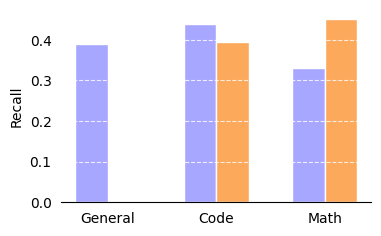

In [185]:
fig = plt.figure(figsize=(4, 2.5))

plt.bar(r1, rec_by_model_and_prompt["simple"], width=barWidth, edgecolor='white', color="#a8a7ff", label='simple')
plt.bar(r2, rec_by_model_and_prompt["tracking"], width=barWidth, edgecolor='white', color="#fca95b", label='tracking')
plt.grid(axis='y', linestyle='--', color="white", alpha=0.8)
#plt.ylim(0, 0.53)

plt.ylabel('Recall')
plt.xlabel('')
plt.xticks([r + barWidth for r in range(len(model_names_extension))], model_names_on_plot)
plt.tick_params(axis='both', which='both', left=False, right=False, bottom=False, top=False)

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.legend(loc='upper center', ncol=3)

plt.savefig(f"./results/eval/plots/recall_prompt.png")
plt.show()

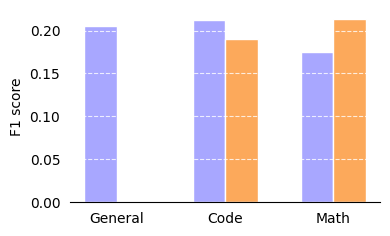

In [186]:
fig = plt.figure(figsize=(4, 2.5))

plt.bar(r1, f1_by_model_and_prompt["simple"], width=barWidth, edgecolor='white', color="#a8a7ff", label='simple')
plt.bar(r2, f1_by_model_and_prompt["tracking"], width=barWidth, edgecolor='white', color="#fca95b", label='tracking')
plt.grid(axis='y', linestyle='--', color="white", alpha=0.8)
#plt.ylim(0, 0.53)

plt.ylabel('F1 score')
plt.xlabel('')
plt.xticks([r + barWidth for r in range(len(model_names_extension))], model_names_on_plot)
plt.tick_params(axis='both', which='both', left=False, right=False, bottom=False, top=False)

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.legend(loc='upper center', ncol=3)

plt.savefig(f"./results/eval/plots/f1_prompt.png")
plt.show()